Notebook to determine the noise level in AZKABAN during zooplankton experiment January 2022 in Ny-Ålesund

In [185]:
import csv
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

import warnings
%matplotlib inline

In [206]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

warnings.simplefilter("ignore")

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16



## Analysis
In Echoview, Single Echo Detection + 0.07m mask on TS data, only noise left.

Export TS (nominal frequency) of noise.

In [413]:
#Read file
fname = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Noise_TS.csv'


time_cols = [0,4,5]
noise_TS = pd.read_csv(fname,header=None, skiprows=1,index_col = 0)#, usecols=np.append(time_cols,TS_cols))


### Make datetime array

In [414]:
times=[]
for ind in range(0,len(noise_TS)):
            times = np.append(times, datetime.strptime('%s.%s' %(noise_TS[4].values[ind],int(noise_TS[5].values[ind])), '%H:%M:%S.%f'))


### Read TS data

In [304]:
start = 15
n_bins = np.shape(noise_TS)[1]-start

TS_cols = np.arange(start,n_bins+start)

In [415]:
depth = pd.read_csv(fname,header=None, skiprows=1, usecols=[8,9], nrows=1)
start_range = depth[8][0]
end_range = depth[9][0]
d_range = (end_range-start_range)/(n_bins-2)
TS_data = pd.read_csv(fname,header=None, skiprows=1,index_col = 0, usecols=TS_cols)
TS_data_thres = np.where(TS_data<-999,np.nan,TS_data) # Change -999 to NaN

### Plot data

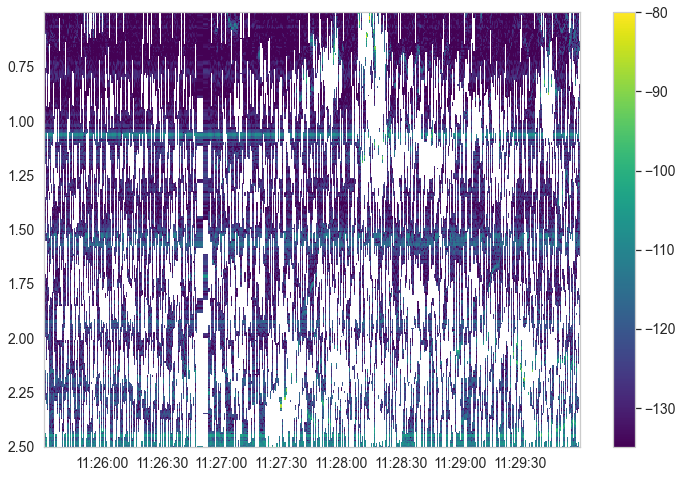

In [422]:
plt.figure(figsize=(12,8))
plt.pcolormesh(times,np.linspace(start_range, end_range,n_bins-1),TS_data_thres.T, cmap="viridis")
plt.clim([-135,-80])
plt.gca().invert_yaxis()
plt.colorbar()

### Project to range axis only (median across time) and smooth
use a 0.1 m depth filter

In [357]:
N = 18  #0.1m/d_range

conv_TS = np.convolve(np.nanmedian(TS_data_thres,0), np.ones(N)/N, mode='full')
smooth_TS = conv_TS[N:-N]

In [358]:
depth_range = np.linspace(start_range, end_range,n_bins-1)
edge = int(N/2)
depth_smooth = depth_range[edge:-edge-1]

### plot noise profile with used range limits indicated

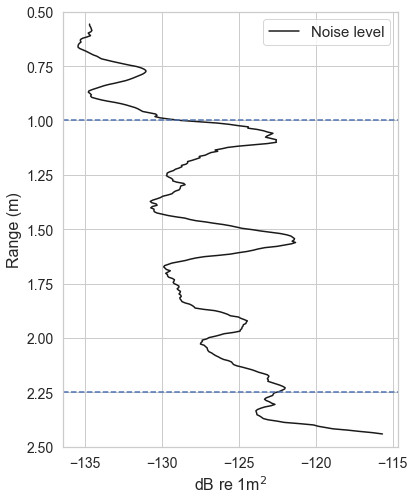

In [370]:
plt.figure(figsize=(6,8))
plt.plot(smooth_TS, depth_smooth, 'k-', label='Noise level')
plt.axhline(1)
plt.axhline(2.25)
plt.ylim([0.5,2.5])
plt.xlabel('dB re 1m$^2$')
plt.ylabel('Range (m)')
plt.legend(fontsize=15)
plt.gca().invert_yaxis()

### Export to file 

In [378]:
noise_df = pd.DataFrame({'range':depth_smooth,'TS':smooth_TS})
noise_df = noise_df.reset_index()

In [379]:
noise_df.to_feather('Noise_AZKABAN_200kHz.feather')

In [380]:
noise_df

,index,range,TS
0,0,0.556864,-134.706115
1,1,0.562773,-134.702960
2,2,0.568682,-134.661552
3,3,0.574591,-134.612129
4,4,0.580500,-134.586824
...,...,...,...
315,315,2.418217,-118.881584
316,316,2.424126,-117.933068
317,317,2.430035,-117.161281
318,318,2.435945,-116.300352
